# Mount Drive and Copy Files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp -r ./gdrive/MyDrive/Table-Tennis-Analysis/* .

# OpenPose

## Download OpenPose

In [ ]:
# !rm -r openpose
# !rm cmake*

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threa

## Generate Images & Json with Skeletons

In [17]:
# input_video = '../8.mp4'
# !chmod -R 777 openpose
# !mkdir train_8 train_8/images train_8/json
# !cd openpose && build/examples/openpose/openpose.bin --video $input_video --write_json ../train_8/json/ --display 0 --write_images ../train_8/images/ --write_images_format jpg

In [18]:
# !zip -r train_8.zip train_8/

In [19]:
input_video = '../test/TEST.mp4'
!chmod -R 777 openpose
!mkdir output output/images output/json
!cd openpose && build/examples/openpose/openpose.bin --video $input_video --write_json ../output/json/ --display 0 --write_images ../output/images/ --write_images_format jpg

chmod: cannot access 'openpose': No such file or directory
/bin/bash: line 0: cd: openpose: No such file or directory


# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install segmentation_models_pytorch
!pip install -U kora

Requirement already up-to-date: kora in /usr/local/lib/python3.7/dist-packages (0.9.19)


In [3]:
import os
import glob
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML
from kora.drive import upload_public
import segmentation_models_pytorch as smp
from src.train import fit, prediction, train
from src.test import test
from src.output import foreback_output
from src.data import loadTrainData, loadTestData, addTrainLabel, addTestLabel, dataAugmentation

# Load Training Data

In [4]:
dirPath = 'train/'
numOfSet = 8
trainData = loadTrainData(dirPath, numOfSet)

# Add Labels to Training Data
labelFile = 'label.csv'
trainData = addTrainLabel(trainData, labelFile)

pd.options.display.max_rows = None
display(trainData)
pd.options.display.max_rows = 50

,train_num,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,...,Third_X6,Third_Y6,Third_X7,Third_Y7,Third_X8,Third_Y8,Third_X9,Third_Y9,Third_X10,Third_Y10,Third_X11,Third_Y11,Third_X12,Third_Y12,Third_X13,Third_Y13,Third_X14,Third_Y14,Third_X15,Third_Y15,Third_X16,Third_Y16,Third_X17,Third_Y17,Third_X18,Third_Y18,Third_X19,Third_Y19,Third_X20,Third_Y20,Third_X21,Third_Y21,Third_X22,Third_Y22,Third_X23,Third_Y23,Third_X24,Third_Y24,left/right,fore/back
0,1,6,724.5690,156.166,768.5790,175.251,746.6070,179.678,724.57800,214.916,701.00700,239.827,790.5660,172.299,784.7540,229.652,733.2700,229.538,796.5260,251.612,783.2450,251.607,761.2720,310.313,758.2780,363.274,812.6620,251.594,792.0030,323.607,803.8810,395.530,723.0870,147.447,730.4100,147.331,0.0000,0.000,746.6260,145.824,...,792.0180,229.645,734.8090,229.538,797.9780,251.620,781.8750,251.629,764.1640,310.325,758.2550,364.740,814.1310,251.600,792.1220,323.593,803.8960,394.146,723.1360,147.398,731.8510,147.292,0.0000,0.000,748.055,145.803,784.711,405.816,793.576,407.309,809.7120,402.864,727.4460,370.607,730.3880,369.055,764.1830,372.090,1,0
1,1,9,727.4390,153.260,768.6120,173.779,746.5150,179.689,712.77500,204.705,674.60400,217.877,792.1000,170.876,792.1360,229.585,737.7380,228.201,797.9830,251.616,781.8660,251.610,765.6090,308.914,758.2600,366.149,815.5130,251.605,793.5280,323.608,805.2470,394.150,724.5190,147.338,733.2510,145.921,0.0000,0.000,750.9380,144.451,...,802.3500,226.658,746.5620,228.121,797.9590,251.593,781.8020,251.610,765.6050,308.911,758.2730,366.160,815.5410,251.589,796.4670,323.645,805.2650,395.531,730.3850,145.915,733.3720,145.848,0.0000,0.000,753.887,142.918,784.752,404.421,793.605,407.283,809.7270,402.882,727.4540,370.605,730.4010,369.050,765.6120,372.107,1,0
2,1,21,129.7290,163.517,98.9212,162.062,76.9282,160.627,41.66790,195.815,75.44850,206.103,119.4330,163.507,116.5410,182.549,123.7960,204.587,69.5046,206.127,53.3766,206.159,87.0872,253.129,62.1351,322.167,85.6679,206.105,122.3720,242.868,112.1740,297.145,123.9460,157.647,134.1420,157.709,109.1800,148.803,0.0000,0.000,...,115.0320,181.118,122.3710,203.115,65.1833,206.119,50.4442,206.170,87.1785,254.631,62.1668,322.165,84.1722,206.074,120.8930,247.199,112.1580,297.139,120.9490,157.653,128.2880,157.694,103.2800,148.810,0.000,0.000,140.022,300.153,135.683,298.665,104.7890,300.158,82.7198,335.366,73.8869,336.821,53.3585,330.902,0,0
3,1,24,122.3920,160.630,91.5870,163.542,75.3189,166.426,54.82950,209.055,88.65620,204.607,112.0790,162.054,112.1870,181.181,119.4550,200.218,65.1516,206.169,51.8606,207.571,87.1602,254.619,62.1968,322.160,81.2554,206.100,115.0300,244.316,112.1850,297.117,118.0020,157.608,123.9140,157.617,100.3740,147.406,0.0000,0.000,...,110.6210,188.480,119.4560,195.822,65.1005,206.120,51.8443,209.037,87.1247,254.569,63.5683,322.154,78.3823,204.612,112.0940,245.759,112.1110,295.682,113.6050,147.414,122.4260,147.422,97.4034,145.820,0.000,0.000,140.005,298.671,135.668,297.150,106.2120,300.150,82.7282,335.390,72.4839,336.836,53.4051,329.462,0,0
4,1,27,116.5320,148.850,88.5919,157.626,73.9366,159.082,87.09460,201.663,120.93800,188.493,101.8650,156.190,109.1790,185.540,125.3370,189.945,65.1431,206.101,51.9089,207.598,87.1116,254.574,63.5711,322.153,79.8025,204.635,110.6380,244.275,112.0840,295.662,112.0670,145.821,122.3100,145.825,93.0136,138.543,0.0000,0.000,...,100.4400,178.183,110.6630,194.390,65.1904,204.584,53.3380,206.051,87.1480,254.548,63.5792,322.141,79.8144,201.692,106.2240,245.762,112.0520,295.676,109.2030,134.146,113.6210,134.086,88.6886,132.684,0.000,0.000,137.122,298.600,135.613,295.669,106.2110,301.559,82.7632,335.365,73.9037,336.821,53.4064,329.447,0,0
5,1,39,733.2900,16

# Data Preprocessing

## Combine Continuous 6 Frames with Same Postures

In [5]:
# print(trainData.shape[0])

ths = ['First_', 'Second_', 'Third_', 'Fourth_', 'Fifth_', 'Sixth_']
cols = ['train_num', 'file_num']
for th in ths:
    for i in range(25):
        cols += [th + 'X' + str(i), th + 'Y' + str(i)]
cols += ['left/right', 'fore/back']
# len(cols)
newdf = pd.DataFrame(columns=cols)

new_index = 0
skip = 0
for index in range(trainData.shape[0]):
    # print(index)
    if(index+2>trainData.shape[0]):
        break
    tmpdf = trainData.iloc[index:index+2,:]
    # display(tmpdf)
    train_num_same = (tmpdf['train_num'][index] == tmpdf['train_num'][index+1])
    file_num_diff_3 = (tmpdf['file_num'][index+1] - tmpdf['file_num'][index] == 3)
    left_right_same = (tmpdf['left/right'][index] == tmpdf['left/right'][index+1])
    fore_back_same = (tmpdf['fore/back'][index] == tmpdf['fore/back'][index+1])

    if (train_num_same and file_num_diff_3 and left_right_same and fore_back_same):
        # display(tmpdf)
        puredf = trainData.iloc[index:index+2,2:-2]
        newdf.loc[new_index] = [tmpdf['train_num'][index], tmpdf['file_num'][index]] + puredf.loc[index].append(puredf.loc[index+1]).tolist() + [tmpdf['left/right'][index],tmpdf['fore/back'][index]]
        new_index += 1

trainData = newdf
display(trainData)

,train_num,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,...,Sixth_X6,Sixth_Y6,Sixth_X7,Sixth_Y7,Sixth_X8,Sixth_Y8,Sixth_X9,Sixth_Y9,Sixth_X10,Sixth_Y10,Sixth_X11,Sixth_Y11,Sixth_X12,Sixth_Y12,Sixth_X13,Sixth_Y13,Sixth_X14,Sixth_Y14,Sixth_X15,Sixth_Y15,Sixth_X16,Sixth_Y16,Sixth_X17,Sixth_Y17,Sixth_X18,Sixth_Y18,Sixth_X19,Sixth_Y19,Sixth_X20,Sixth_Y20,Sixth_X21,Sixth_Y21,Sixth_X22,Sixth_Y22,Sixth_X23,Sixth_Y23,Sixth_X24,Sixth_Y24,left/right,fore/back
0,1.0,6.0,724.569,156.166,768.5790,175.251,746.6070,179.678,724.5780,214.916,701.0070,239.827,790.566,172.299,784.754,229.652,733.270,229.538,796.5260,251.612,783.2450,251.607,761.2720,310.313,758.2780,363.274,812.6620,251.594,792.003,323.607,803.881,395.530,723.087,147.447,730.410,147.331,0.000,0.000,746.626,145.824,...,802.350,226.658,746.562,228.121,797.9590,251.593,781.8020,251.610,765.6050,308.911,758.2730,366.160,815.5410,251.589,796.467,323.645,805.265,395.531,730.385,145.915,733.372,145.848,0.0000,0.000,753.887,142.918,784.752,404.421,793.605,407.283,809.727,402.882,727.4540,370.605,730.4010,369.050,765.6120,372.107,1.0,0.0
1,1.0,21.0,129.729,163.517,98.9212,162.062,76.9282,160.627,41.6679,195.815,75.4485,206.103,119.433,163.507,116.541,182.549,123.796,204.587,69.5046,206.127,53.3766,206.159,87.0872,253.129,62.1351,322.167,85.6679,206.105,122.372,242.868,112.174,297.145,123.946,157.647,134.142,157.709,109.180,148.803,0.000,0.000,...,110.621,188.480,119.456,195.822,65.1005,206.120,51.8443,209.037,87.1247,254.569,63.5683,322.154,78.3823,204.612,112.094,245.759,112.111,295.682,113.605,147.414,122.426,147.422,97.4034,145.820,0.000,0.000,140.005,298.671,135.668,297.150,106.212,300.150,82.7282,335.390,72.4839,336.836,53.4051,329.462,0.0,0.0
2,1.0,24.0,122.392,160.630,91.5870,163.542,75.3189,166.426,54.8295,209.055,88.6562,204.607,112.079,162.054,112.187,181.181,119.455,200.218,65.1516,206.169,51.8606,207.571,87.1602,254.619,62.1968,322.160,81.2554,206.100,115.030,244.316,112.185,297.117,118.002,157.608,123.914,157.617,100.374,147.406,0.000,0.000,...,100.440,178.183,110.663,194.390,65.1904,204.584,53.3380,206.051,87.1480,254.548,63.5792,322.141,79.8144,201.692,106.224,245.762,112.052,295.676,109.203,134.146,113.621,134.086,88.6886,132.684,0.000,0.000,137.122,298.600,135.613,295.669,106.211,301.559,82.7632,335.365,73.9037,336.821,53.4064,329.447,0.0,0.0
3,1.0,39.0,733.290,164.962,777.3950,182.657,758.3340,184.085,734.7760,210.519,701.0380,223.722,793.537,182.649,793.577,242.800,739.235,236.962,808.2670,258.949,795.0480,254.620,765.6540,307.462,764.1480,360.322,822.9400,260.455,784.735,325.104,814.096,398.496,733.230,159.043,734.794,157.631,0.000,0.000,756.763,153.240,...,817.009,229.582,764.188,229.531,812.6470,250.187,795.0110,250.140,771.4930,305.945,765.6100,358.907,827.3470,251.593,796.473,322.141,815.535,394.127,734.867,145.960,743.617,145.870,0.0000,0.000,762.693,142.975,796.460,395.590,803.767,402.859,818.538,402.886,734.8020,369.064,734.8660,361.809,770.0520,370.536,1.0,0.0
4,1.0,69.0,731.822,164.997,774.4320,182.563,758.2710,184.105,731.8860,206.078,693.6570,209.030,792.069,181.103,795.036,238.406,745.005,231.098,808.2700,254.576,794.9890,254.580,758.2760,300.138,768.6360,358.819,825.8220,254.563,792.045,322.043,818.511,394.110,0.000,0.000,733.311,157.660,0.000,0.000,749.475,153.243,...,805.350,217.938,755.385,216.421,805.3110,242.853,790.6130,244.273,759.7440,298.686,768.6160,358.784,822.9060,242.829,805.327,319.155,821.455,392.612,0.000,0.000,733.309,140.018,0.0000,0.000,749.509,135.690,803.817,398.512,812.641,402.901,827.367,395.567,739.1930,367.631,742.1630,360.354,777.3690,367.649,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

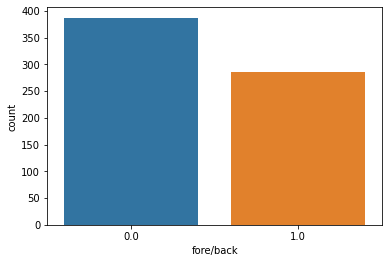

In [6]:
import seaborn as sns
sns.countplot(x=trainData['fore/back'], data=trainData)
plt.show()

## Left / Right Division

### Right

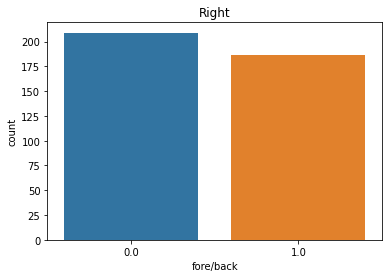

Fore/Back Rate: 0.8947


In [7]:
rightTrainData = trainData[trainData['left/right'] == 1].drop(columns=['left/right'])
sns.countplot(x=rightTrainData['fore/back'], data=rightTrainData).set_title('Right')
plt.show()
print('Fore/Back Rate: %.4f' % (len(rightTrainData[rightTrainData['fore/back'] == 1]) / len(rightTrainData[rightTrainData['fore/back'] == 0])))

### Left

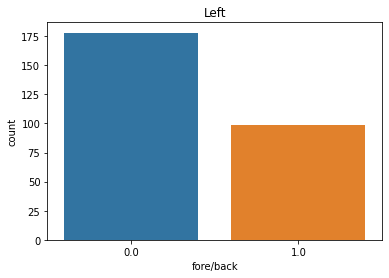

Fore/Back Rate: 0.5562


In [8]:
leftTrainData = trainData[trainData['left/right'] == 0].drop(columns=['left/right'])
sns.countplot(x=leftTrainData['fore/back'], data=leftTrainData).set_title('Left')
plt.show()
print('Fore/Back Rate: %.4f' % (len(leftTrainData[leftTrainData['fore/back'] == 1]) / len(leftTrainData[leftTrainData['fore/back'] == 0])))

##Data Augmentation##

In [9]:
rightTrainData = dataAugmentation(rightTrainData)
rightTrainData

,train_num,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,...,Sixth_Y5,Sixth_X6,Sixth_Y6,Sixth_X7,Sixth_Y7,Sixth_X8,Sixth_Y8,Sixth_X9,Sixth_Y9,Sixth_X10,Sixth_Y10,Sixth_X11,Sixth_Y11,Sixth_X12,Sixth_Y12,Sixth_X13,Sixth_Y13,Sixth_X14,Sixth_Y14,Sixth_X15,Sixth_Y15,Sixth_X16,Sixth_Y16,Sixth_X17,Sixth_Y17,Sixth_X18,Sixth_Y18,Sixth_X19,Sixth_Y19,Sixth_X20,Sixth_Y20,Sixth_X21,Sixth_Y21,Sixth_X22,Sixth_Y22,Sixth_X23,Sixth_Y23,Sixth_X24,Sixth_Y24,fore/back
0,1.0,6.0,724.569,156.166,768.579,175.251,746.607,179.678,724.578,214.916,701.007,239.827,790.566,172.299,784.754,229.652,733.270,229.538,796.526,251.612,783.245,251.607,761.272,310.313,758.278,363.274,812.662,251.594,792.003,323.607,803.881,395.530,723.087,147.447,730.410,147.331,0.0,0.0,746.626,145.824,...,170.795,802.350,226.658,746.562,228.121,797.959,251.593,781.802,251.610,765.605,308.911,758.273,366.160,815.541,251.589,796.467,323.645,805.265,395.531,730.385,145.915,733.372,145.848,0.0,0.0,753.887,142.918,784.752,404.421,793.605,407.283,809.727,402.882,727.454,370.605,730.401,369.050,765.612,372.107,0.0
1,1.0,39.0,733.290,164.962,777.395,182.657,758.334,184.085,734.776,210.519,701.038,223.722,793.537,182.649,793.577,242.800,739.235,236.962,808.267,258.949,795.048,254.620,765.654,307.462,764.148,360.322,822.940,260.455,784.735,325.104,814.096,398.496,733.230,159.043,734.794,157.631,0.0,0.0,756.763,153.240,...,170.898,817.009,229.582,764.188,229.531,812.647,250.187,795.011,250.140,771.493,305.945,765.610,358.907,827.347,251.593,796.473,322.141,815.535,394.127,734.867,145.960,743.617,145.870,0.0,0.0,762.693,142.975,796.460,395.590,803.767,402.859,818.538,402.886,734.802,369.064,734.866,361.809,770.052,370.536,0.0
2,1.0,69.0,731.822,164.997,774.432,182.563,758.271,184.105,731.886,206.078,693.657,209.030,792.069,181.103,795.036,238.406,745.005,231.098,808.270,254.576,794.989,254.580,758.276,300.138,768.636,358.819,825.822,254.563,792.045,322.043,818.511,394.110,0.000,0.000,733.311,157.660,0.0,0.0,749.475,153.243,...,166.442,805.350,217.938,755.385,216.421,805.311,242.853,790.613,244.273,759.744,298.686,768.616,358.784,822.906,242.829,805.327,319.155,821.455,392.612,0.000,0.000,733.309,140.018,0.0,0.0,749.509,135.690,803.817,398.512,812.641,402.901,827.367,395.567,739.193,367.631,742.163,360.354,777.369,367.649,0.0
3,1.0,96.0,734.858,170.900,783.244,189.913,767.076,192.833,743.612,212.001,706.908,217.858,803.783,185.574,812.635,244.279,758.309,239.946,815.630,261.895,800.915,260.467,758.319,305.994,770.060,358.890,830.274,261.929,793.578,323.653,827.268,398.517,734.748,169.299,739.190,165.000,0.0,0.0,758.284,159.198,...,170.930,825.814,226.610,771.505,226.690,815.631,250.147,800.873,248.717,768.626,303.039,770.061,358.915,831.721,251.578,811.178,322.125,825.824,395.529,0.000,0.000,740.694,148.824,0.0,0.0,758.358,145.956,806.755,402.869,815.585,404.398,828.859,402.874,742.147,369.078,745.046,363.271,778.890,369.123,0.0
4,1.0,123.0,733.280,181.151,780.278,195.803,767.073,198.746,745.132,217.848,709.880,225.200,792.126,194.375,803.893,251.573,753.917,250.127,815.554,266.357,800.911,266.318,758.337,310.428,771.532,369.063,828.765,267.801,793.547,333.867,827.360,404.345,0.000,0.000,734.766,172.375,0.0,0.0,752.421,170.868,...,181.099,808.227,231.093,758.280,229.621,814.116,256.050,797.930,256.054,765.640,310.345,771.516,370.533,828.738,257.504,814.066,332.357,828.776,404.338,0.000,0.000,733.379,159.093,0.0,0.0,750.957,157.557,814.058,407.333,818.539,411.725,836.161,407.321,743.608,379.379,745.093,372.105,780.386,379.390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [10]:
leftTrainData = dataAugmentation(leftTrainData)
leftTrainData

,train_num,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,...,Sixth_Y5,Sixth_X6,Sixth_Y6,Sixth_X7,Sixth_Y7,Sixth_X8,Sixth_Y8,Sixth_X9,Sixth_Y9,Sixth_X10,Sixth_Y10,Sixth_X11,Sixth_Y11,Sixth_X12,Sixth_Y12,Sixth_X13,Sixth_Y13,Sixth_X14,Sixth_Y14,Sixth_X15,Sixth_Y15,Sixth_X16,Sixth_Y16,Sixth_X17,Sixth_Y17,Sixth_X18,Sixth_Y18,Sixth_X19,Sixth_Y19,Sixth_X20,Sixth_Y20,Sixth_X21,Sixth_Y21,Sixth_X22,Sixth_Y22,Sixth_X23,Sixth_Y23,Sixth_X24,Sixth_Y24,fore/back
0,1.0,21.0,129.729,163.517,98.9212,162.062,76.9282,160.627,41.6679,195.815,75.4485,206.103,119.433,163.507,116.541,182.549,123.796,204.587,69.5046,206.127,53.3766,206.159,87.0872,253.129,62.1351,322.167,85.6679,206.105,122.372,242.868,112.174,297.145,123.946,157.647,134.142,157.709,109.180,148.803,0.0,0.0,...,159.097,110.6210,188.480,119.456,195.822,65.1005,206.120,51.8443,209.037,87.1247,254.569,63.5683,322.154,78.3823,204.612,112.094,245.759,112.111,295.682,113.605,147.414,122.426,147.422,97.4034,145.820,0.0,0.0,140.005,298.671,135.668,297.150,106.212,300.150,82.7282,335.390,72.4839,336.836,53.4051,329.462,0.0
1,1.0,24.0,122.392,160.630,91.5870,163.542,75.3189,166.426,54.8295,209.055,88.6562,204.607,112.079,162.054,112.187,181.181,119.455,200.218,65.1516,206.169,51.8606,207.571,87.1602,254.619,62.1968,322.160,81.2554,206.100,115.030,244.316,112.185,297.117,118.002,157.608,123.914,157.617,100.374,147.406,0.0,0.0,...,145.893,100.4400,178.183,110.663,194.390,65.1904,204.584,53.3380,206.051,87.1480,254.548,63.5792,322.141,79.8144,201.692,106.224,245.762,112.052,295.676,109.203,134.146,113.621,134.086,88.6886,132.684,0.0,0.0,137.122,298.600,135.613,295.669,106.211,301.559,82.7632,335.365,73.9037,336.821,53.4064,329.447,0.0
2,1.0,81.0,147.410,148.813,112.0970,150.297,100.3520,154.700,88.6417,194.349,131.2080,192.808,123.870,147.419,110.654,181.155,126.809,197.286,75.3525,201.690,62.1792,203.155,87.1477,253.060,66.5803,322.104,87.1620,200.240,126.822,239.872,122.348,295.663,145.907,144.398,151.754,144.375,128.250,135.636,0.0,0.0,...,125.381,97.4462,159.143,119.442,181.106,70.9866,195.854,62.1447,197.312,84.1746,253.111,66.6120,322.138,79.7881,194.427,122.337,238.415,122.315,294.231,147.354,128.244,154.672,128.285,128.2580,123.905,0.0,0.0,147.376,300.129,145.869,298.617,112.106,300.105,87.1849,333.929,76.8993,335.359,62.1932,329.460,0.0
3,1.0,111.0,157.663,156.138,123.8360,154.725,113.5730,159.075,118.0110,203.111,156.1620,192.893,132.681,147.420,132.621,185.549,0.000,0.000,82.7440,204.696,69.5275,206.068,85.6845,258.947,70.9774,325.098,95.9561,204.685,135.567,242.820,123.858,300.080,154.723,147.400,159.157,147.395,135.685,144.387,0.0,0.0,...,132.643,129.7340,169.353,135.630,182.634,81.2890,203.187,70.9668,204.568,75.4463,258.978,65.1568,325.090,93.0365,204.563,129.744,242.846,123.831,300.160,150.336,131.231,157.700,129.741,134.1290,125.312,0.0,0.0,150.296,310.305,147.358,305.941,115.069,310.351,87.1641,332.400,78.3363,335.322,62.1647,335.309,0.0
4,1.0,138.0,163.513,169.403,129.7180,169.367,122.3110,173.799,113.5640,216.391,148.8290,207.577,135.662,160.616,129.720,201.692,145.906,210.536,87.1930,217.828,75.3761,217.882,88.5632,272.213,75.3131,336.862,100.3890,217.806,138.569,256.039,126.781,311.829,159.141,162.081,167.893,163.505,144.366,159.046,0.0,0.0,...,145.847,142.9480,154.691,147.426,159.112,88.5587,216.328,76.8177,216.363,84.1814,272.191,72.4594,338.300,100.3090,216.316,134.185,256.054,126.823,313.310,159.108,147.422,166.475,147.370,141.4730,145.864,0.0,0.0,156.142,322.067,150.330,317.740,120.924,322.063,97.4060,347.113,87.1814,350.060,65.1146,347.150,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

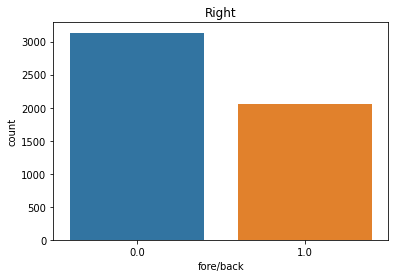

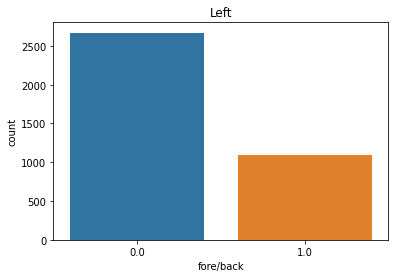

In [11]:
import seaborn as sns
sns.countplot(x=rightTrainData['fore/back'], data=rightTrainData).set_title('Right')
plt.show()

sns.countplot(x=leftTrainData['fore/back'], data=leftTrainData).set_title('Left')
plt.show()

# Model Construction and Validation

## DO NOT RUN THE FOLLOWING 5 CELLS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [ ]:
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=300))
    model.add(LSTM(256))
    # model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='relu'))
    model.add(Dense(1))
    model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
scores = model.evaluate(x_Test_norm, y_TestOneHot) 

In [ ]:
train_history = model.fit(

In [ ]:
rightTrainData.shape

## SAFE TO RUN FROM HERE

In [12]:
print('Right Validation')
SVMright = train('SVM', 'linear', rightTrainData)

Right Validation
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       604
         1.0       1.00      1.00      1.00       435

    accuracy                           1.00      1039
   macro avg       1.00      1.00      1.00      1039
weighted avg       1.00      1.00      1.00      1039



In [13]:
print('Left Validation')
SVMleft = train('SVM', 'rbf', leftTrainData)

Left Validation
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       529
         1.0       1.00      0.94      0.97       223

    accuracy                           0.98       752
   macro avg       0.99      0.97      0.98       752
weighted avg       0.98      0.98      0.98       752



In [14]:
model_table = torch.load('Semantic_Segmentation/best_model_2.pth').to('cuda')
model_ball = torch.load('Ball_tracking/ball_model.pth').to('cuda')

# Test

## Load Test Data

In [15]:
# !cp -r /content/gdrive/MyDrive/Table-Tennis-Analysis/test/output ./

In [16]:
testData = loadTestData('test/output/json', '7_')
testData = addTestLabel(testData, labelFile, 7).drop(columns=['train_num'])
testData

,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,First_X19,...,Third_X6,Third_Y6,Third_X7,Third_Y7,Third_X8,Third_Y8,Third_X9,Third_Y9,Third_X10,Third_Y10,Third_X11,Third_Y11,Third_X12,Third_Y12,Third_X13,Third_Y13,Third_X14,Third_Y14,Third_X15,Third_Y15,Third_X16,Third_Y16,Third_X17,Third_Y17,Third_X18,Third_Y18,Third_X19,Third_Y19,Third_X20,Third_Y20,Third_X21,Third_Y21,Third_X22,Third_Y22,Third_X23,Third_Y23,Third_X24,Third_Y24,left/right,fore/back
0,30,109.1980,184.134,68.0460,192.854,54.8381,194.401,57.7654,251.578,109.204,235.467,79.8374,188.455,76.8044,228.124,0.000,0.000,32.8192,251.567,18.1560,253.086,69.5363,310.326,41.6277,383.815,48.9853,248.658,87.2005,295.690,97.4304,345.626,101.8930,181.067,110.6960,181.098,84.2204,172.368,0.000,0.000,123.853,...,0.0000,0.000,0.000,0.000,31.3347,250.132,18.1667,253.048,66.6351,308.860,41.6480,383.802,43.1282,244.278,84.2158,295.695,94.5094,345.643,98.9152,173.778,107.6810,173.787,76.8600,170.823,0.000,0.000,122.435,345.598,120.909,342.681,88.6136,354.410,72.4835,394.154,63.6429,398.498,31.3880,392.648,0,0
1,33,100.3880,179.624,62.1270,184.118,53.4289,195.868,84.1760,233.988,135.632,219.303,63.6328,170.916,62.1946,170.888,0.000,0.000,32.8203,251.557,19.6251,253.075,66.5868,307.452,41.6442,383.787,44.5647,245.784,81.2503,297.138,93.0502,345.657,97.4205,170.840,101.8360,170.827,75.3326,169.300,0.000,0.000,122.380,...,0.0000,0.000,0.000,0.000,37.1943,248.705,25.4423,253.042,65.1838,307.433,41.6417,382.412,47.4792,242.816,76.8749,297.145,91.5799,345.628,91.5543,160.568,98.9582,159.181,70.9847,159.099,0.000,0.000,120.952,344.158,117.985,341.205,88.5800,352.989,72.4592,394.121,63.6249,397.044,31.3892,392.632,0,0
2,36,98.8131,162.030,54.8832,178.194,53.3359,187.010,82.7211,223.732,134.075,216.398,59.2606,163.539,0.0000,0.000,0.000,0.000,37.1775,245.742,25.4680,251.614,65.1526,305.987,41.6376,382.406,46.0532,241.321,76.8414,295.675,90.1377,345.562,90.0557,157.617,98.8672,157.604,68.0847,156.170,0.000,0.000,122.346,...,65.0882,207.571,81.294,231.074,40.0896,244.279,26.9538,250.169,65.1352,305.986,41.6254,382.408,51.8634,239.937,78.3100,292.744,87.1999,344.119,88.5922,147.334,98.8055,147.316,65.2074,147.308,0.000,0.000,116.539,342.666,112.178,336.865,82.7453,348.597,72.4520,394.117,63.6057,397.042,31.3855,392.618,0,0
3,42,734.8810,176.735,786.2220,194.332,780.3180,195.877,784.7220,239.945,746.617,242.795,793.5860,191.402,827.3610,231.128,806.792,283.924,828.7930,283.918,815.6070,282.471,781.7530,332.370,781.8100,402.853,840.6080,283.956,839.0500,366.203,869.8950,452.815,0.0000,0.000,742.1100,169.407,0.0000,0.000,759.817,170.805,837.611,...,828.8060,228.172,803.834,276.547,825.8820,282.448,809.6970,282.465,777.3530,330.942,781.7730,402.850,840.5120,282.451,839.0000,360.293,865.5330,449.908,0.0000,0.000,736.3050,169.336,0.0000,0.000,758.317,169.451,839.023,466.070,849.369,469.001,877.2870,457.228,748.0180,405.796,750.9520,402.911,790.6140,407.356,1,0
4,45,734.7420,170.936,781.8230,192.922,764.1890,203.163,734.8550,235.480,698.051,228.147,802.3550,182.675,833.1890,225.162,803.890,269.256,821.4410,279.512,805.2720,280.980,774.4560,330.906,781.7450,401.425,839.0230,278.077,837.5600,358.816,862.5900,445.499,0.0000,0.000,736.3210,167.871,0.0000,0.000,758.353,169.354,837.570,...,840.5090,216.403,806.823,260.439,817.1170,278.095,802.3840,279.522,773.0220,329.465,781.7400,401.408,837.5690,278.047,831.7380,355.917,858.1920,439.652,0.0000,0.000,740.6990,159.130,0.0000,0.000,761.246,160.628,837.626,464.653,850.755,464.638,869.9240,445.478,748.0220,405.776,750.9720,402.889,789.1640,407.316,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [17]:
lr_groups = testData.groupby('left/right')
right = lr_groups.get_group(1)
left = lr_groups.get_group(0)
testData = right.append(left, ignore_index=True)
testData

,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,First_X19,...,Third_X6,Third_Y6,Third_X7,Third_Y7,Third_X8,Third_Y8,Third_X9,Third_Y9,Third_X10,Third_Y10,Third_X11,Third_Y11,Third_X12,Third_Y12,Third_X13,Third_Y13,Third_X14,Third_Y14,Third_X15,Third_Y15,Third_X16,Third_Y16,Third_X17,Third_Y17,Third_X18,Third_Y18,Third_X19,Third_Y19,Third_X20,Third_Y20,Third_X21,Third_Y21,Third_X22,Third_Y22,Third_X23,Third_Y23,Third_X24,Third_Y24,left/right,fore/back
0,42,734.881,176.735,786.2220,194.332,780.3180,195.877,784.7220,239.945,746.617,242.795,793.5860,191.402,827.3610,231.128,806.792,283.924,828.7930,283.918,815.6070,282.471,781.7530,332.370,781.8100,402.853,840.6080,283.956,839.050,366.203,869.895,452.815,0.000,0.000,742.110,169.407,0.0000,0.000,759.817,170.805,837.611,...,828.8060,228.172,803.834,276.547,825.8820,282.448,809.6970,282.465,777.3530,330.942,781.7730,402.850,840.5120,282.451,839.000,360.293,865.533,449.908,0.000,0.000,736.305,169.336,0.0000,0.000,758.317,169.451,839.023,466.070,849.369,469.001,877.287,457.228,748.0180,405.796,750.9520,402.911,790.6140,407.356,1,0
1,45,734.742,170.936,781.8230,192.922,764.1890,203.163,734.8550,235.480,698.051,228.147,802.3550,182.675,833.1890,225.162,803.890,269.256,821.4410,279.512,805.2720,280.980,774.4560,330.906,781.7450,401.425,839.0230,278.077,837.560,358.816,862.590,445.499,0.000,0.000,736.321,167.871,0.0000,0.000,758.353,169.354,837.570,...,840.5090,216.403,806.823,260.439,817.1170,278.095,802.3840,279.522,773.0220,329.465,781.7400,401.408,837.5690,278.047,831.738,355.917,858.192,439.652,0.000,0.000,740.699,159.130,0.0000,0.000,761.246,160.628,837.626,464.653,850.755,464.638,869.924,445.478,748.0220,405.776,750.9720,402.889,789.1640,407.316,1,0
2,48,736.256,162.021,781.7770,184.080,756.7720,194.348,709.8960,213.447,667.278,206.045,806.8160,176.722,843.5080,214.889,814.104,253.163,817.0870,278.060,802.3130,279.518,775.9030,329.447,781.7510,399.945,837.5830,276.621,831.762,355.865,856.711,438.171,0.000,0.000,742.157,157.580,0.0000,0.000,764.163,157.694,836.114,...,850.8240,207.564,818.560,251.561,815.6380,275.145,797.9350,276.549,778.8590,329.476,781.7580,399.946,836.1120,275.113,836.129,348.607,855.251,433.764,0.000,0.000,745.078,145.942,0.0000,0.000,768.535,147.448,828.818,461.625,840.560,461.654,865.557,441.083,748.0670,404.383,752.4480,402.847,789.1540,405.901,1,0
3,75,733.372,169.333,780.3590,187.012,780.2810,185.561,786.2260,232.516,758.245,222.284,781.7700,185.558,815.5850,223.699,814.094,275.100,817.0820,276.565,805.3470,275.144,770.0790,322.142,781.7740,395.536,828.7750,276.633,818.526,355.853,861.111,438.093,0.000,0.000,734.876,160.583,0.0000,0.000,755.329,165.000,836.102,...,819.9830,216.416,793.525,264.820,814.1250,273.633,800.8630,273.635,770.0700,322.172,781.7780,395.535,827.3230,273.633,822.893,345.673,855.220,429.362,0.000,0.000,734.846,157.611,0.0000,0.000,755.309,159.079,830.281,451.381,842.023,452.787,865.527,438.163,750.9490,402.920,755.3250,398.496,790.6020,404.395,1,1
4,78,733.357,159.112,780.2760,181.172,768.5270,185.576,745.0460,216.422,701.058,204.640,792.0740,175.258,824.4020,216.329,792.081,256.071,811.1830,272.191,795.0470,272.210,770.0620,322.140,781.7810,394.108,827.2650,272.179,822.914,344.172,852.254,427.848,0.000,0.000,734.871,154.677,0.0000,0.000,755.360,157.600,827.309,...,828.8520,210.511,791.992,244.321,808.2520,267.779,793.5300,267.813,770.0230,322.118,781.8650,394.071,827.2590,267.780,824.357,341.220,847.891,423.463,0.000,0.000,736.303,147.371,0.0000,0.000,756.869,150.296,819.970,445.467,831.735,446.976,856.705,429.360,752.4270,402.906,755.3790,397.043,792.1080,404.296,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [18]:
ths = ['First_', 'Second_', 'Third_', 'Fourth_', 'Fifth_', 'Sixth_']
cols = ['file_num']
for th in ths:
    for i in range(25):
        cols += [th + 'X' + str(i), th + 'Y' + str(i)]
cols += ['left/right', 'fore/back']
# len(cols)

del newdf
newdf = pd.DataFrame(columns=cols)

new_index = 0
for index in range(testData.shape[0]):
    # print(index)
    if(index+2>testData.shape[0]):
        break
    tmpdf = testData.iloc[index:index+2,:]
    # display(tmpdf)
    file_num_diff_3 = (tmpdf['file_num'][index+1] - tmpdf['file_num'][index] == 3)
    left_right_same = (tmpdf['left/right'][index] == tmpdf['left/right'][index+1])
    
    puredf = testData.iloc[index:index+2,1:-2]

    if (file_num_diff_3 and left_right_same):
        # display(tmpdf)
        newdf.loc[new_index] = [tmpdf['file_num'][index]] + puredf.loc[index].append(puredf.loc[index+1]).tolist() + [tmpdf['left/right'][index]] + [tmpdf['fore/back'][index]]
        new_index += 1

display(newdf)
testData = newdf

,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,First_X19,...,Sixth_X6,Sixth_Y6,Sixth_X7,Sixth_Y7,Sixth_X8,Sixth_Y8,Sixth_X9,Sixth_Y9,Sixth_X10,Sixth_Y10,Sixth_X11,Sixth_Y11,Sixth_X12,Sixth_Y12,Sixth_X13,Sixth_Y13,Sixth_X14,Sixth_Y14,Sixth_X15,Sixth_Y15,Sixth_X16,Sixth_Y16,Sixth_X17,Sixth_Y17,Sixth_X18,Sixth_Y18,Sixth_X19,Sixth_Y19,Sixth_X20,Sixth_Y20,Sixth_X21,Sixth_Y21,Sixth_X22,Sixth_Y22,Sixth_X23,Sixth_Y23,Sixth_X24,Sixth_Y24,left/right,fore/back
0,42.0,734.881,176.735,786.2220,194.332,780.3180,195.877,784.7220,239.945,746.617,242.795,793.586,191.402,827.3610,231.128,806.792,283.924,828.7930,283.918,815.6070,282.471,781.7530,332.370,781.8100,402.853,840.6080,283.956,839.050,366.203,869.895,452.815,0.000,0.000,742.110,169.407,0.000,0.000,759.817,170.805,837.611,...,840.5090,216.403,806.823,260.439,817.1170,278.095,802.3840,279.522,773.0220,329.465,781.7400,401.408,837.5690,278.047,831.738,355.917,858.192,439.652,0.000,0.000,740.699,159.130,0.0000,0.000,761.246,160.628,837.626,464.653,850.755,464.638,869.924,445.478,748.0220,405.776,750.9720,402.889,789.1640,407.316,1.0,0.0
1,45.0,734.742,170.936,781.8230,192.922,764.1890,203.163,734.8550,235.480,698.051,228.147,802.355,182.675,833.1890,225.162,803.890,269.256,821.4410,279.512,805.2720,280.980,774.4560,330.906,781.7450,401.425,839.0230,278.077,837.560,358.816,862.590,445.499,0.000,0.000,736.321,167.871,0.000,0.000,758.353,169.354,837.570,...,850.8240,207.564,818.560,251.561,815.6380,275.145,797.9350,276.549,778.8590,329.476,781.7580,399.946,836.1120,275.113,836.129,348.607,855.251,433.764,0.000,0.000,745.078,145.942,0.0000,0.000,768.535,147.448,828.818,461.625,840.560,461.654,865.557,441.083,748.0670,404.383,752.4480,402.847,789.1540,405.901,1.0,0.0
2,75.0,733.372,169.333,780.3590,187.012,780.2810,185.561,786.2260,232.516,758.245,222.284,781.770,185.558,815.5850,223.699,814.094,275.100,817.0820,276.565,805.3470,275.144,770.0790,322.142,781.7740,395.536,828.7750,276.633,818.526,355.853,861.111,438.093,0.000,0.000,734.876,160.583,0.000,0.000,755.329,165.000,836.102,...,828.8520,210.511,791.992,244.321,808.2520,267.779,793.5300,267.813,770.0230,322.118,781.8650,394.071,827.2590,267.780,824.357,341.220,847.891,423.463,0.000,0.000,736.303,147.371,0.0000,0.000,756.869,150.296,819.970,445.467,831.735,446.976,856.705,429.360,752.4270,402.906,755.3790,397.043,792.1080,404.296,1.0,1.0
3,78.0,733.357,159.112,780.2760,181.172,768.5270,185.576,745.0460,216.422,701.058,204.640,792.074,175.258,824.4020,216.329,792.081,256.071,811.1830,272.191,795.0470,272.210,770.0620,322.140,781.7810,394.108,827.2650,272.179,822.914,344.172,852.254,427.848,0.000,0.000,734.871,154.677,0.000,0.000,755.360,157.600,827.309,...,840.5000,207.563,800.887,241.375,806.7370,266.350,790.5680,266.354,768.5410,320.659,784.7200,392.590,827.2770,266.346,827.306,338.260,846.401,419.105,0.000,0.000,743.610,144.378,0.0000,0.000,764.201,145.925,824.400,445.474,837.576,445.512,853.769,429.282,752.4430,402.903,756.7680,397.020,793.5900,401.427,1.0,1.0
4,81.0,734.822,153.222,780.2980,176.753,758.2540,182.553,724.5070,204.606,689.298,182.571,802.342,170.819,834.6850,209.025,792.085,241.408,806.7840,266.318,792.0870,266.364,769.9980,322.095,783.2700,392.672,825.8730,264.906,825.798,338.300,844.964,421.968,0.000,0.000,739.199,145.930,0.000,0.000,758.347,148.803,818.554,...,850.7540,213.447,814.132,247.245,805.2880,275.074,784.7320,275.066,764.1660,322.102,784.7170,391.124,827.2770,275.083,830.245,345.573,853.755,424.913,746.499,144.434,748.068,144.394,0.0000,0.000,771.518,147.301,828.761,441.134,840.539,443.997,864.057,430.819,755.3410,402.927,756.8200,397.042,793.6170,397.021,1.0,1.0
...,...,...,...,...,...,...,.

## Accuracy

In [19]:
rightTestData = testData[testData['left/right'] == 1].drop(columns=['left/right'])
leftTestData = testData[testData['left/right'] == 0].drop(columns=['left/right'])

In [20]:
display(rightTestData)
display(leftTestData)

,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,First_X19,...,Sixth_Y5,Sixth_X6,Sixth_Y6,Sixth_X7,Sixth_Y7,Sixth_X8,Sixth_Y8,Sixth_X9,Sixth_Y9,Sixth_X10,Sixth_Y10,Sixth_X11,Sixth_Y11,Sixth_X12,Sixth_Y12,Sixth_X13,Sixth_Y13,Sixth_X14,Sixth_Y14,Sixth_X15,Sixth_Y15,Sixth_X16,Sixth_Y16,Sixth_X17,Sixth_Y17,Sixth_X18,Sixth_Y18,Sixth_X19,Sixth_Y19,Sixth_X20,Sixth_Y20,Sixth_X21,Sixth_Y21,Sixth_X22,Sixth_Y22,Sixth_X23,Sixth_Y23,Sixth_X24,Sixth_Y24,fore/back
0,42.0,734.881,176.735,786.222,194.332,780.318,195.877,784.722,239.945,746.617,242.795,793.586,191.402,827.361,231.128,806.792,283.924,828.793,283.918,815.607,282.471,781.753,332.370,781.810,402.853,840.608,283.956,839.050,366.203,869.895,452.815,0.000,0.000,742.110,169.407,0.0,0.0,759.817,170.805,837.611,...,181.067,840.509,216.403,806.823,260.439,817.117,278.095,802.384,279.522,773.022,329.465,781.740,401.408,837.569,278.047,831.738,355.917,858.192,439.652,0.000,0.000,740.699,159.130,0.0,0.0,761.246,160.628,837.626,464.653,850.755,464.638,869.924,445.478,748.022,405.776,750.972,402.889,789.164,407.316,0.0
1,45.0,734.742,170.936,781.823,192.922,764.189,203.163,734.855,235.480,698.051,228.147,802.355,182.675,833.189,225.162,803.890,269.256,821.441,279.512,805.272,280.980,774.456,330.906,781.745,401.425,839.023,278.077,837.560,358.816,862.590,445.499,0.000,0.000,736.321,167.871,0.0,0.0,758.353,169.354,837.570,...,170.902,850.824,207.564,818.560,251.561,815.638,275.145,797.935,276.549,778.859,329.476,781.758,399.946,836.112,275.113,836.129,348.607,855.251,433.764,0.000,0.000,745.078,145.942,0.0,0.0,768.535,147.448,828.818,461.625,840.560,461.654,865.557,441.083,748.067,404.383,752.448,402.847,789.154,405.901,0.0
2,75.0,733.372,169.333,780.359,187.012,780.281,185.561,786.226,232.516,758.245,222.284,781.770,185.558,815.585,223.699,814.094,275.100,817.082,276.565,805.347,275.144,770.079,322.142,781.774,395.536,828.775,276.633,818.526,355.853,861.111,438.093,0.000,0.000,734.876,160.583,0.0,0.0,755.329,165.000,836.102,...,170.889,828.852,210.511,791.992,244.321,808.252,267.779,793.530,267.813,770.023,322.118,781.865,394.071,827.259,267.780,824.357,341.220,847.891,423.463,0.000,0.000,736.303,147.371,0.0,0.0,756.869,150.296,819.970,445.467,831.735,446.976,856.705,429.360,752.427,402.906,755.379,397.043,792.108,404.296,1.0
3,78.0,733.357,159.112,780.276,181.172,768.527,185.576,745.046,216.422,701.058,204.640,792.074,175.258,824.402,216.329,792.081,256.071,811.183,272.191,795.047,272.210,770.062,322.140,781.781,394.108,827.265,272.179,822.914,344.172,852.254,427.848,0.000,0.000,734.871,154.677,0.0,0.0,755.360,157.600,827.309,...,169.446,840.500,207.563,800.887,241.375,806.737,266.350,790.568,266.354,768.541,320.659,784.720,392.590,827.277,266.346,827.306,338.260,846.401,419.105,0.000,0.000,743.610,144.378,0.0,0.0,764.201,145.925,824.400,445.474,837.576,445.512,853.769,429.282,752.443,402.903,756.768,397.020,793.590,401.427,1.0
4,81.0,734.822,153.222,780.298,176.753,758.254,182.553,724.507,204.606,689.298,182.571,802.342,170.819,834.685,209.025,792.085,241.408,806.784,266.318,792.087,266.364,769.998,322.095,783.270,392.672,825.873,264.906,825.798,338.300,844.964,421.968,0.000,0.000,739.199,145.930,0.0,0.0,758.347,148.803,818.554,...,172.322,850.754,213.447,814.132,247.245,805.288,275.074,784.732,275.066,764.166,322.102,784.717,391.124,827.277,275.083,830.245,345.573,853.755,424.913,746.499,144.434,748.068,144.394,0.0,0.0,771.518,147.301,828.761,441.134,840.539,443.997,864.057,430.819,755.341,402.927,756.820,397.042,793.617,397.021,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

,file_num,First_X0,First_Y0,First_X1,First_Y1,First_X2,First_Y2,First_X3,First_Y3,First_X4,First_Y4,First_X5,First_Y5,First_X6,First_Y6,First_X7,First_Y7,First_X8,First_Y8,First_X9,First_Y9,First_X10,First_Y10,First_X11,First_Y11,First_X12,First_Y12,First_X13,First_Y13,First_X14,First_Y14,First_X15,First_Y15,First_X16,First_Y16,First_X17,First_Y17,First_X18,First_Y18,First_X19,...,Sixth_Y5,Sixth_X6,Sixth_Y6,Sixth_X7,Sixth_Y7,Sixth_X8,Sixth_Y8,Sixth_X9,Sixth_Y9,Sixth_X10,Sixth_Y10,Sixth_X11,Sixth_Y11,Sixth_X12,Sixth_Y12,Sixth_X13,Sixth_Y13,Sixth_X14,Sixth_Y14,Sixth_X15,Sixth_Y15,Sixth_X16,Sixth_Y16,Sixth_X17,Sixth_Y17,Sixth_X18,Sixth_Y18,Sixth_X19,Sixth_Y19,Sixth_X20,Sixth_Y20,Sixth_X21,Sixth_Y21,Sixth_X22,Sixth_Y22,Sixth_X23,Sixth_Y23,Sixth_X24,Sixth_Y24,fore/back
60,30.0,109.1980,184.134,68.0460,192.854,54.83810,194.401,57.76540,251.578,109.20400,235.467,79.8374,188.455,76.8044,228.124,0.0000,0.000,32.8192,251.567,18.1560,253.086,69.5363,310.326,41.6277,383.815,48.9853,248.658,87.2005,295.690,97.4304,345.626,101.8930,181.067,110.696,181.098,84.2204,172.368,0.0000,0.000,123.8530,...,166.449,0.0000,0.000,0.0000,0.000,37.1943,248.705,25.44230,253.042,65.1838,307.433,41.6417,382.412,47.4792,242.816,76.8749,297.145,91.5799,345.628,91.5543,160.568,98.9582,159.181,70.9847,159.099,0.0,0.0,120.952,344.158,117.9850,341.205,88.5800,352.989,72.4592,394.121,63.6249,397.044,31.3892,392.632,0.0
61,33.0,100.3880,179.624,62.1270,184.118,53.42890,195.868,84.17600,233.988,135.63200,219.303,63.6328,170.916,62.1946,170.888,0.0000,0.000,32.8203,251.557,19.6251,253.075,66.5868,307.452,41.6442,383.787,44.5647,245.784,81.2503,297.138,93.0502,345.657,97.4205,170.840,101.836,170.827,75.3326,169.300,0.0000,0.000,122.3800,...,167.881,65.0882,207.571,81.2940,231.074,40.0896,244.279,26.95380,250.169,65.1352,305.986,41.6254,382.408,51.8634,239.937,78.3100,292.744,87.1999,344.119,88.5922,147.334,98.8055,147.316,65.2074,147.308,0.0,0.0,116.539,342.666,112.1780,336.865,82.7453,348.597,72.4520,394.117,63.6057,397.042,31.3855,392.618,0.0
62,57.0,106.2400,188.466,65.0872,191.437,53.37060,191.446,47.50830,244.275,87.16320,239.843,76.8175,189.975,65.1297,223.736,88.6001,239.902,28.3673,254.547,15.1619,260.435,62.2030,310.441,28.3836,386.751,41.6333,251.639,90.0800,289.870,81.2629,345.632,101.8400,181.137,110.621,182.540,85.6305,173.792,0.0000,0.000,112.1320,...,162.046,44.5604,198.775,63.6214,217.921,21.0650,251.572,10.76990,253.122,54.8377,308.925,28.3540,386.751,31.3653,247.210,68.0872,289.864,76.8789,345.616,98.8651,160.631,101.8660,163.524,76.8410,159.080,0.0,0.0,109.126,345.564,103.3130,342.660,73.8821,354.411,60.7204,395.577,51.8777,401.421,18.0915,395.532,0.0
63,60.0,104.7480,181.097,56.3276,182.549,56.30290,194.344,79.78160,239.916,126.83500,217.900,56.3245,169.395,56.3206,169.429,0.0000,0.000,25.4757,253.143,15.1943,260.405,62.1645,311.782,28.3836,388.198,37.2276,251.611,76.9058,289.837,78.3707,345.661,100.3990,170.951,109.154,172.391,79.8347,169.333,0.0000,0.000,110.6910,...,150.306,3.4194,181.111,51.8892,211.992,18.1581,248.708,15.13370,251.631,51.8274,308.871,28.3486,386.771,28.4006,245.769,63.6074,292.768,75.3505,345.574,90.0861,147.293,98.8290,147.368,70.9885,144.426,0.0,0.0,103.313,341.239,100.3820,336.839,68.0632,354.405,60.7382,395.549,51.8981,401.402,18.1002,395.571,0.0
64,93.0,40.1558,170.810,29.9507,182.602,4.13304,182.677,4.15109,223.737,4.14619,226.636,62.2117,181.098,63.6617,207.596,75.4597,238.378,28.3212,260.463,0.0000,0.000,0.0000,0.000,0.0000,0.000,43.0770,260.414,73.8825,308.892,65.1229,348.617,29.9603,164.953,44.549,162.031,16.7354,159.157,53.3023,159.043,95.9545,...,172.302,46.0274,206.157,68.0641,228.123,18.1485,251.673,4.12667,254.564,40.1172,313.347,21.0405,394.080,32.7822,250.123,63.7038,298.693,71.0071,354.404,53.4118,150.280,65.1229,148.810,32.8520,148.876,0.0,0.0,101.814,357.316,98.9429,351.502,65.0929,360.281,44.5748,407.308,35.7515,410.248,16.5938,402.916,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [21]:
testDataW_Pred = test('SVM', rightTestData, leftTestData, SVMright, SVMleft)

Right               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        34
         1.0       1.00      0.88      0.94        26

    accuracy                           0.95        60
   macro avg       0.96      0.94      0.95        60
weighted avg       0.95      0.95      0.95        60

Left               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        42
         1.0       1.00      0.60      0.75        15

    accuracy                           0.89        57
   macro avg       0.94      0.80      0.84        57
weighted avg       0.91      0.89      0.89        57



## Video Output

In [22]:
foreback_output('test/output/images', '7_', rightTestData, leftTestData, SVMright, SVMleft, model_table, model_ball, 'demo.mp4')
!cp demo.mp4 gdrive/MyDrive/Table-Tennis-Analysis/

100%|██████████| 889/889 [01:03<00:00, 13.91it/s]


## Show video

In [23]:
# url = upload_public('demo.mp4')
# # then display it
# HTML(f"""<video src={url} width=600 controls/>""")